In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor

# READ DATA

In [2]:
df = pd.read_csv('data/train.csv')
pd.set_option('display.max_columns', len(df.columns))
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
print(f"Total number of observations is {len(df)}")

Total number of observations is 1460


# MISSING DATA

<AxesSubplot:>

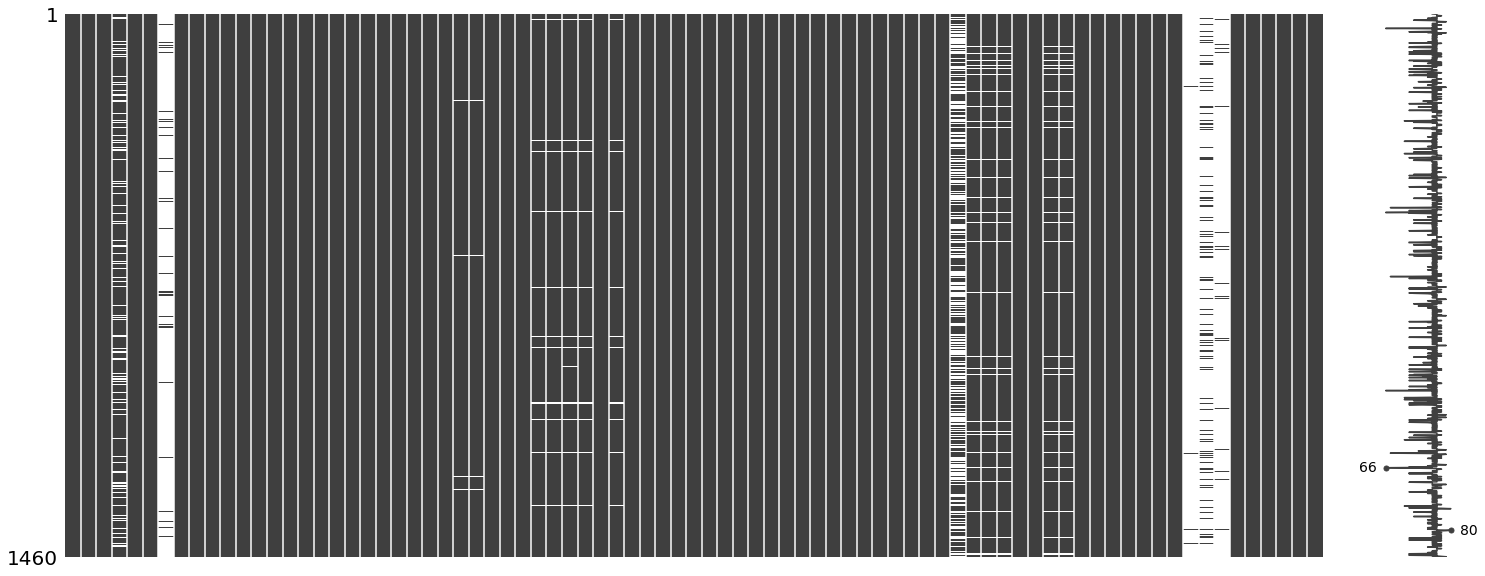

In [4]:
msno.matrix(df)

We can see that there missing values in the dataset. We will first remove the columns where there are too many missing data.

In [5]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


If we take 15% of missing data as threshold, we can remove the columns 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu' and 'LotFrontage'.

In [6]:
# drop columns because too many NaN values
to_remove = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']
df = df.drop(to_remove, axis=1)

Then, we have to remove th remaining rows where there are missing values.

In [7]:
# drop remaining row containing NaN values
df = df.dropna()

In [8]:
print(f"New number of observations is {len(df)}")

New number of observations is 1338


So, we have removed 6 columns and 122 rows.

# DATA CLEANING

In [9]:
def get_num_cat_var(df):
    num_var = list(df._get_numeric_data().columns)
    cat_var = list(set(df.columns) - set(num_var))
    
    return num_var, cat_var

num_var, cat_var = get_num_cat_var(df)

In [10]:
df[num_var].nunique().sort_values(ascending=False).head()

Id           1338
LotArea      1000
GrLivArea     822
BsmtUnfSF     764
1stFlrSF      727
dtype: int64

In [11]:
df[cat_var].nunique().sort_values(ascending=False).head()

Neighborhood    25
Exterior2nd     16
Exterior1st     14
SaleType         9
Condition1       9
dtype: int64

In [12]:
# we remove Id 
df = df.drop(['Id'], axis=1)

num_var, cat_var = get_num_cat_var(df)

# CORRELATION

<AxesSubplot:>

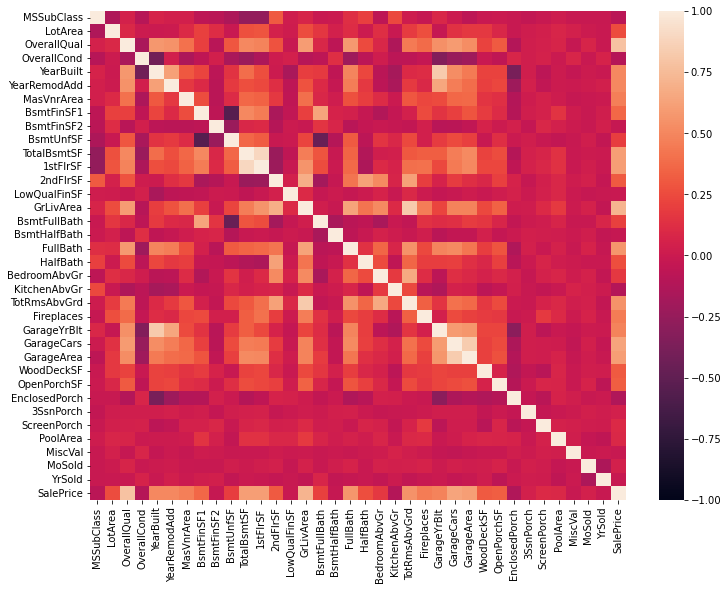

In [13]:
corr_mat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=1, vmin=-1)

# DATA EXPLORATION

In [32]:
df['SalePrice'].describe()

count      1338.000000
mean     186761.782511
std       78913.847668
min       35311.000000
25%      135000.000000
50%      168500.000000
75%      220000.000000
max      755000.000000
Name: SalePrice, dtype: float64

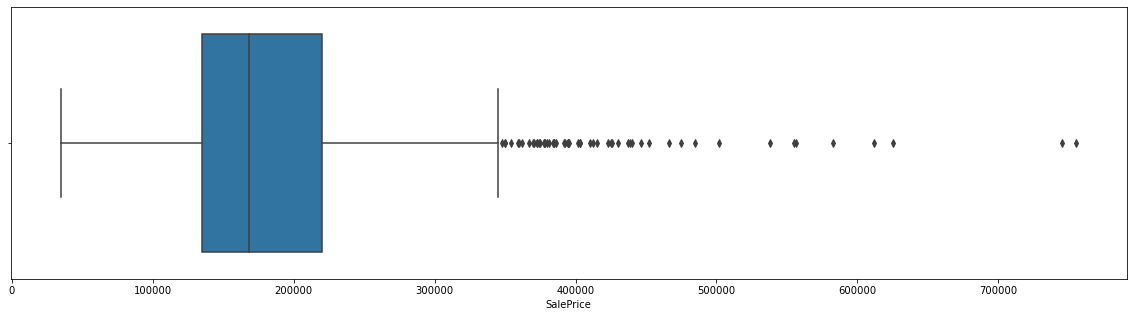

In [31]:
f, ax = plt.subplots(figsize=(20, 5))
fig = sns.boxplot(df['SalePrice'])

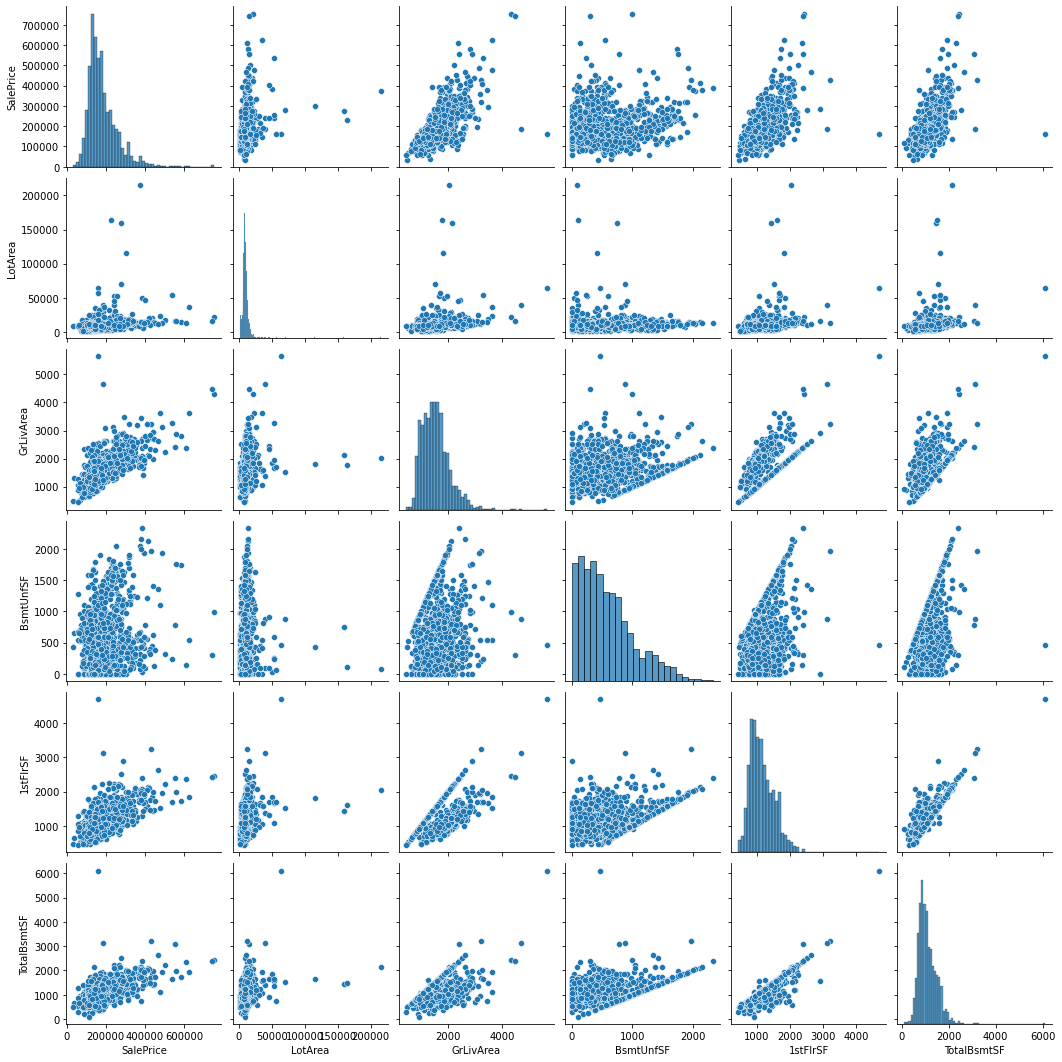

In [15]:
sns.pairplot(df[['SalePrice', 'LotArea', 'GrLivArea', 'BsmtUnfSF', '1stFlrSF', 'TotalBsmtSF']])

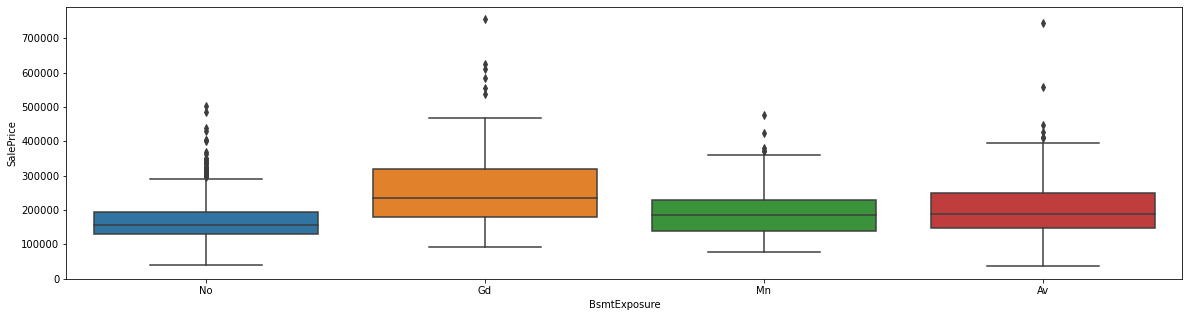

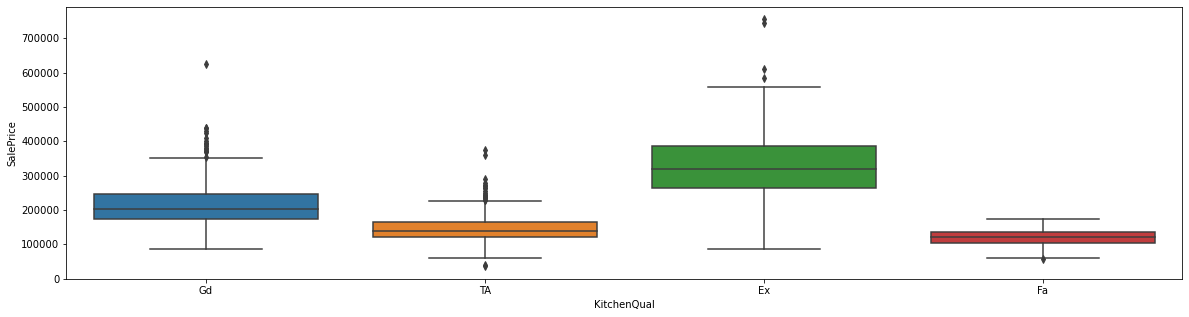

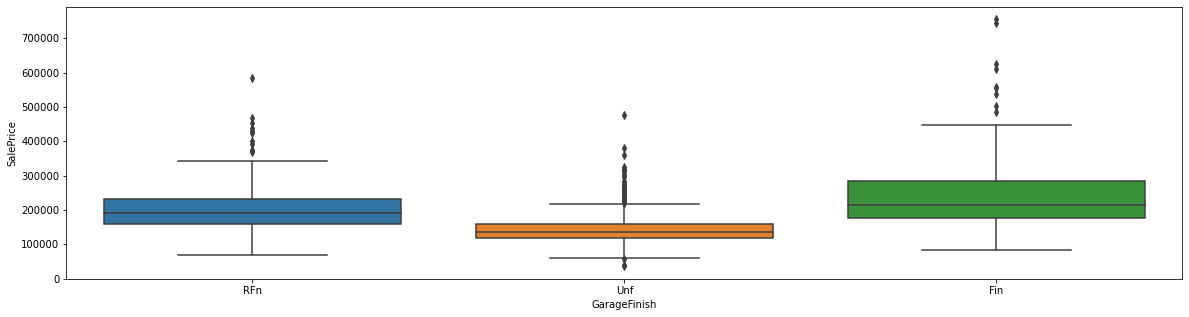

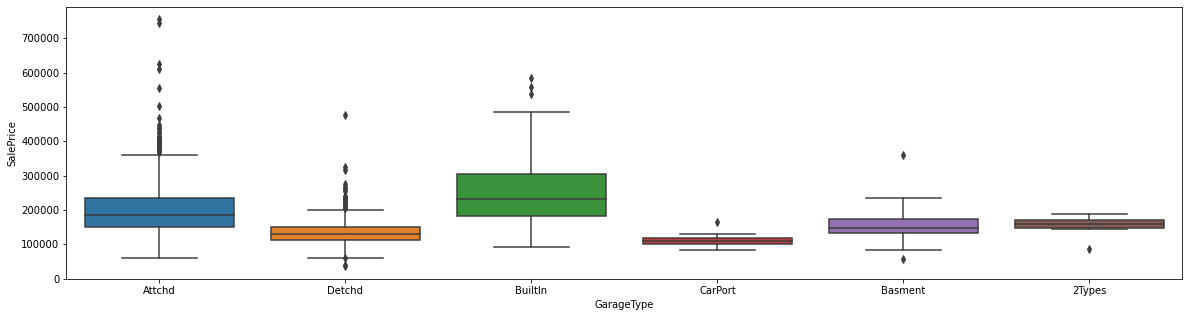

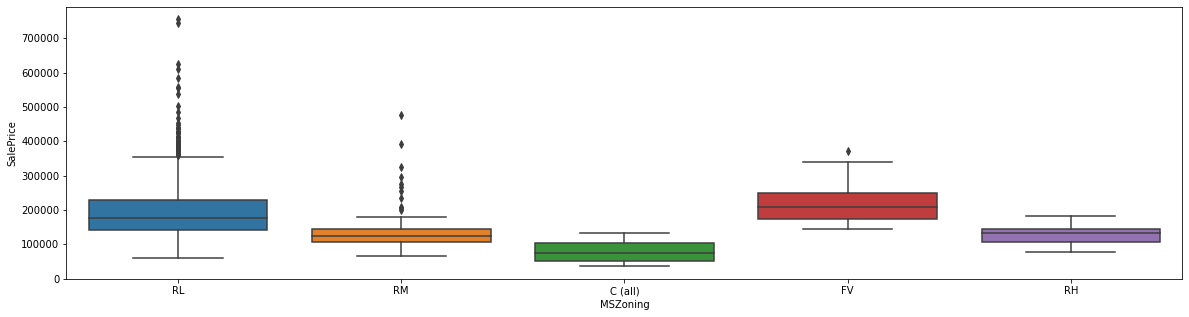

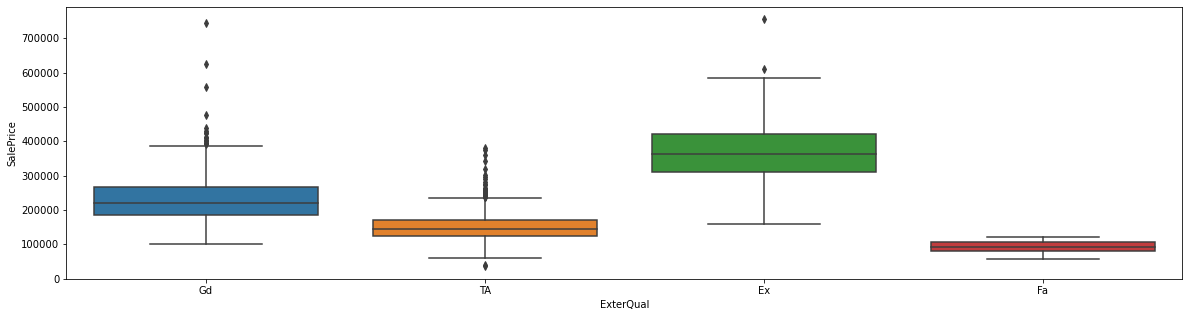

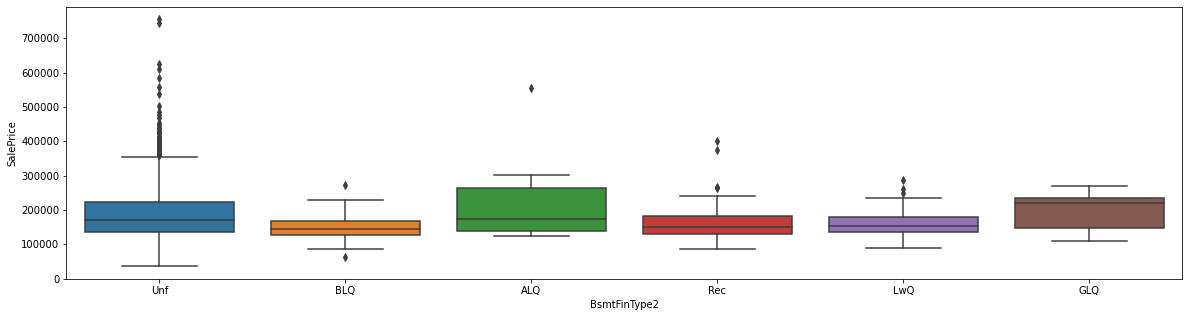

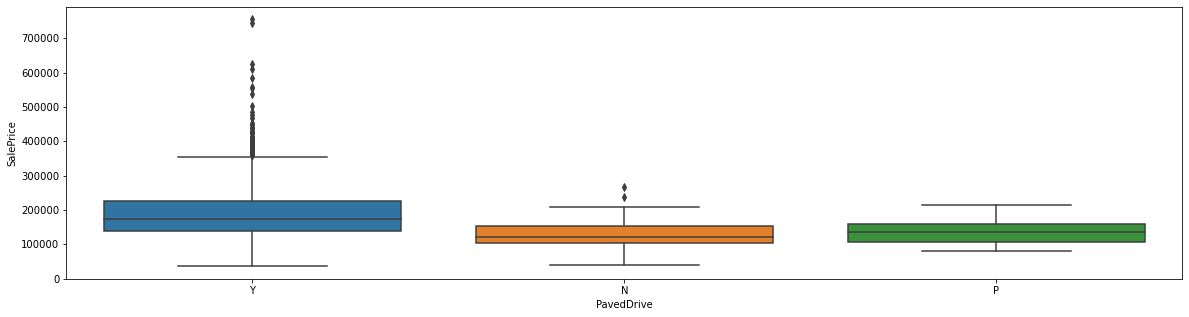

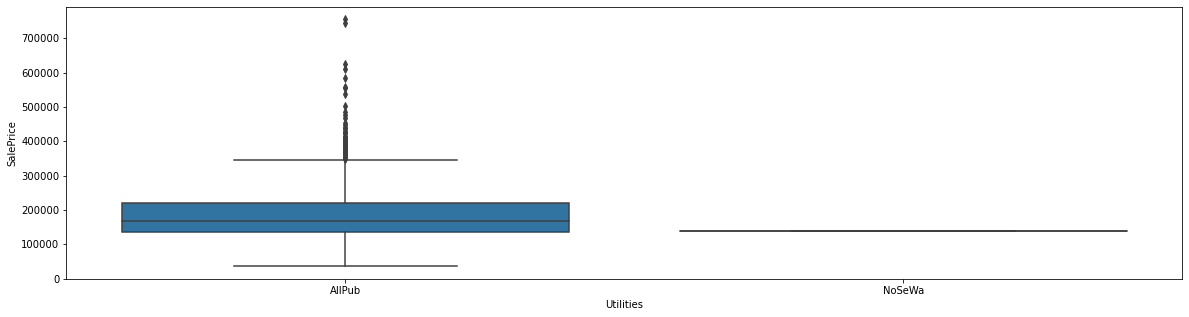

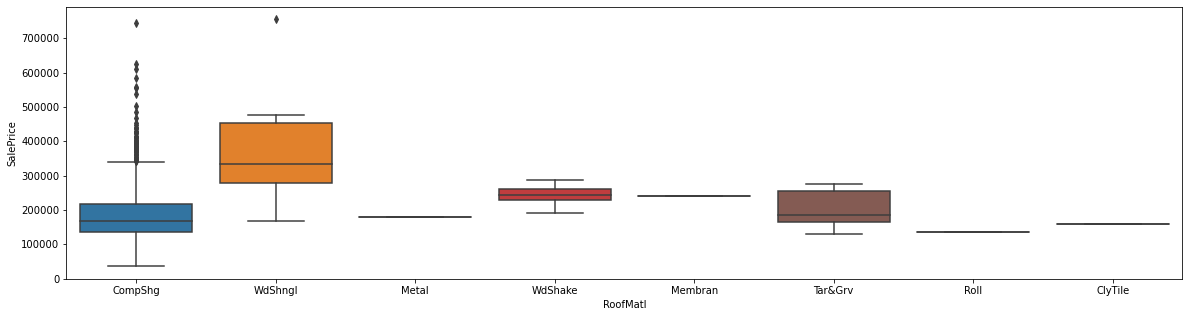

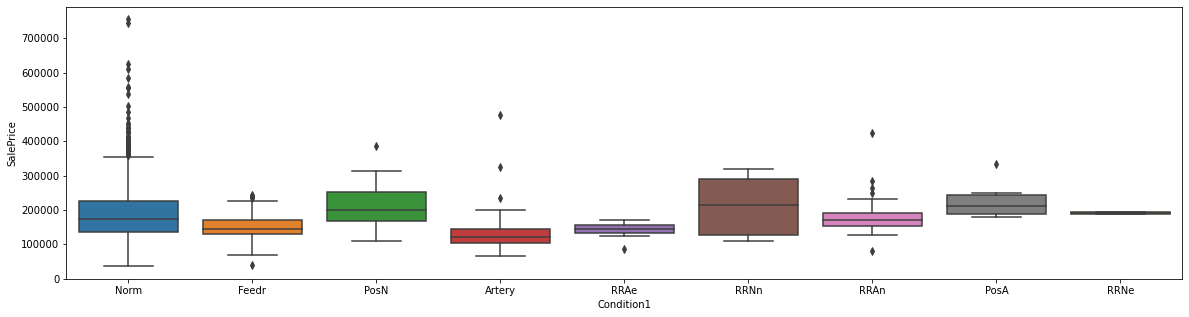

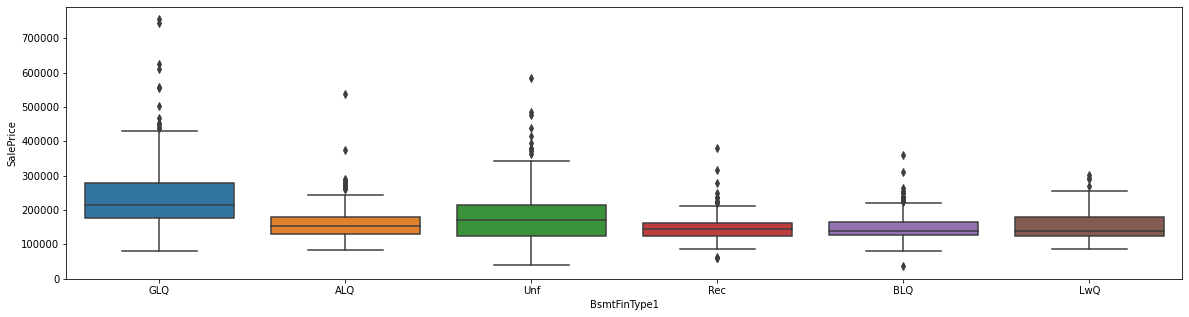

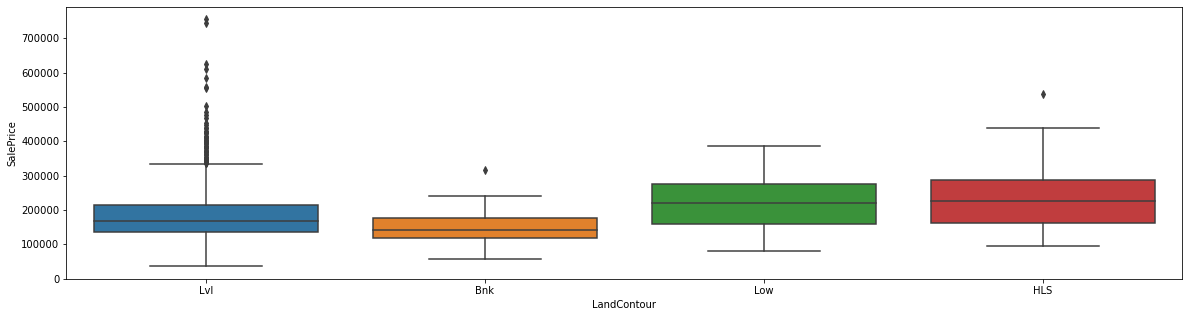

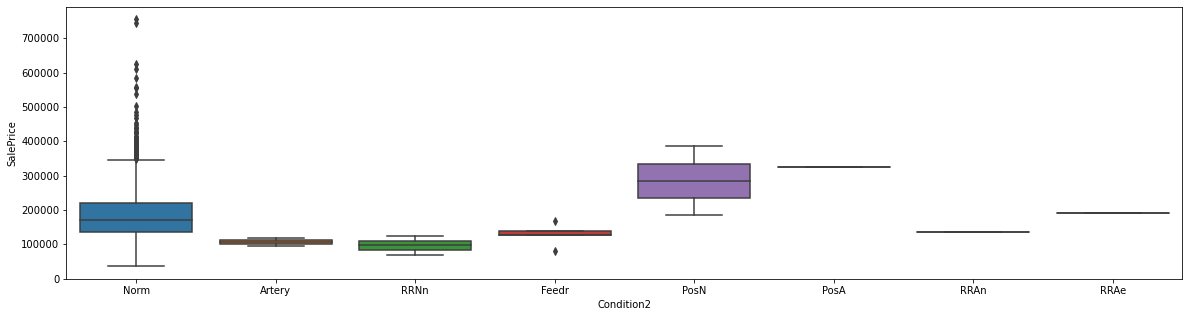

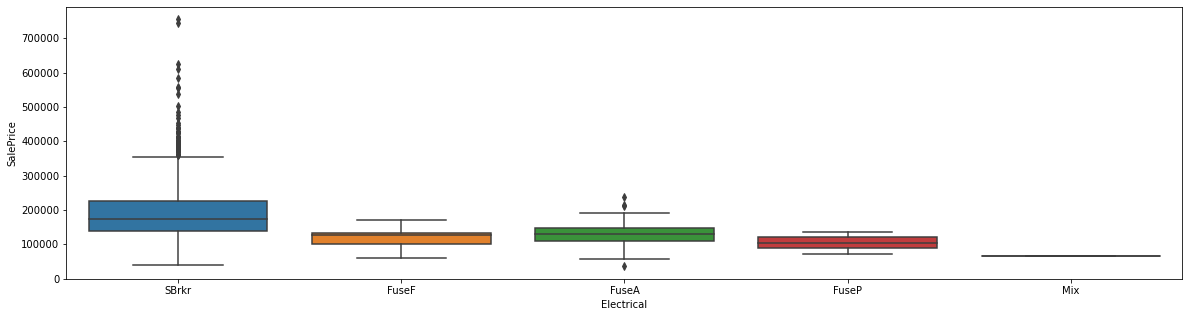

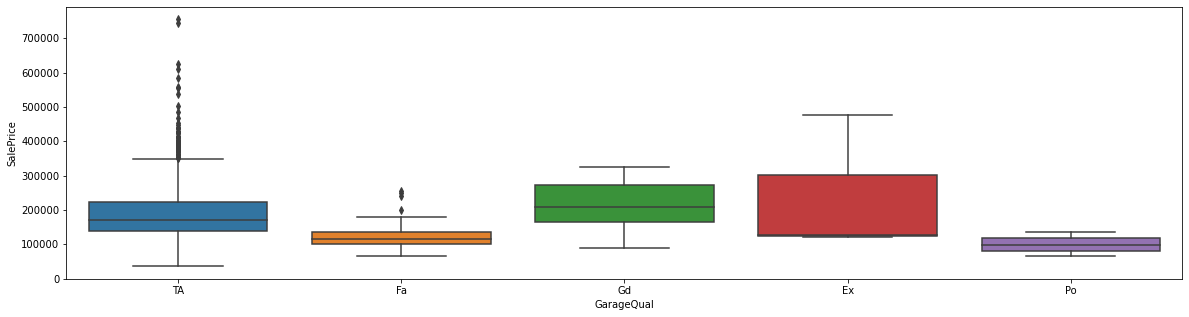

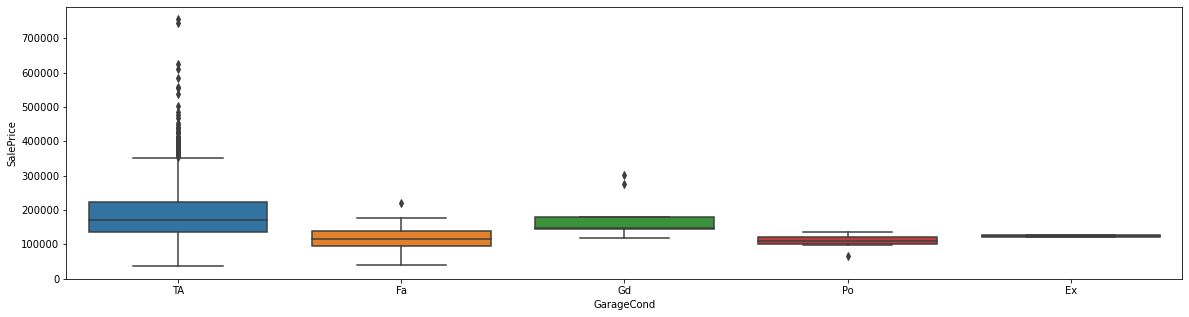

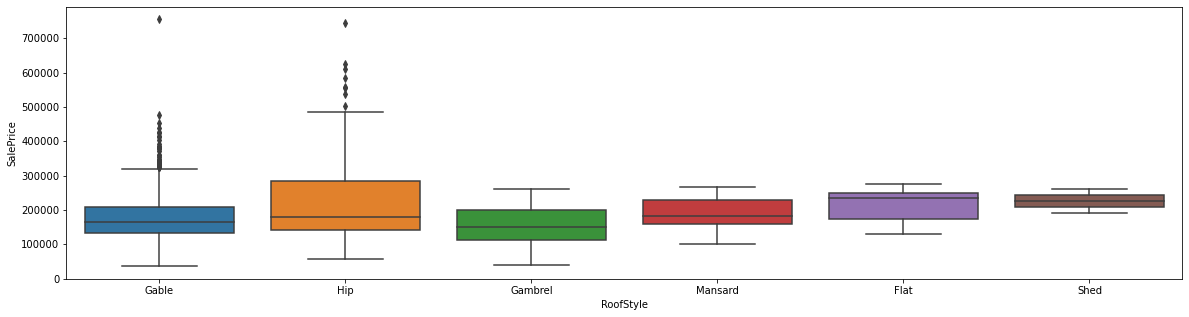

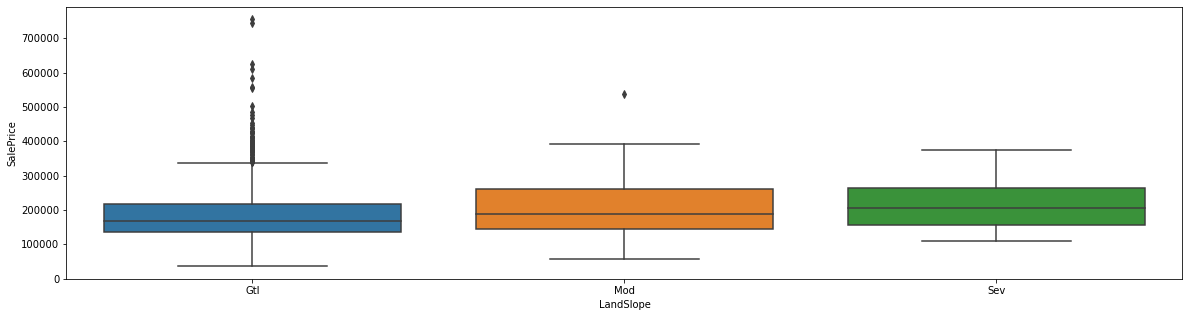

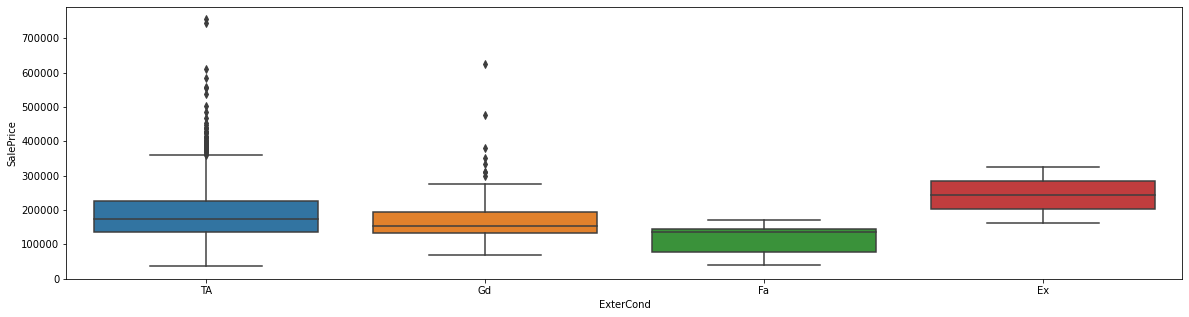

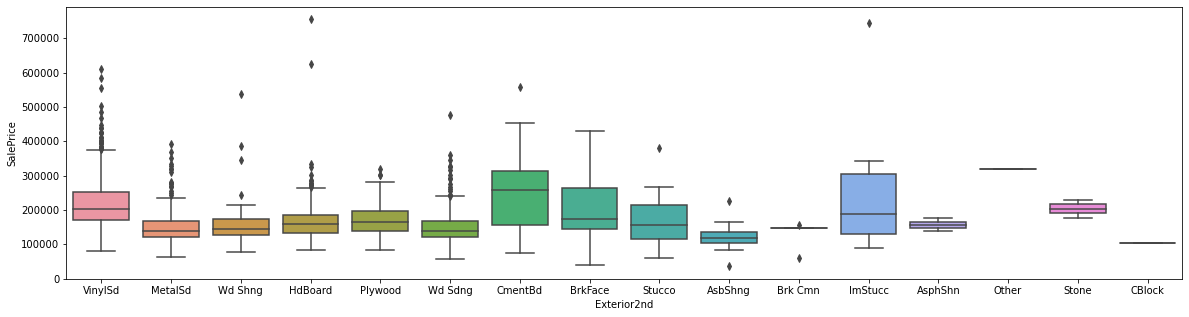

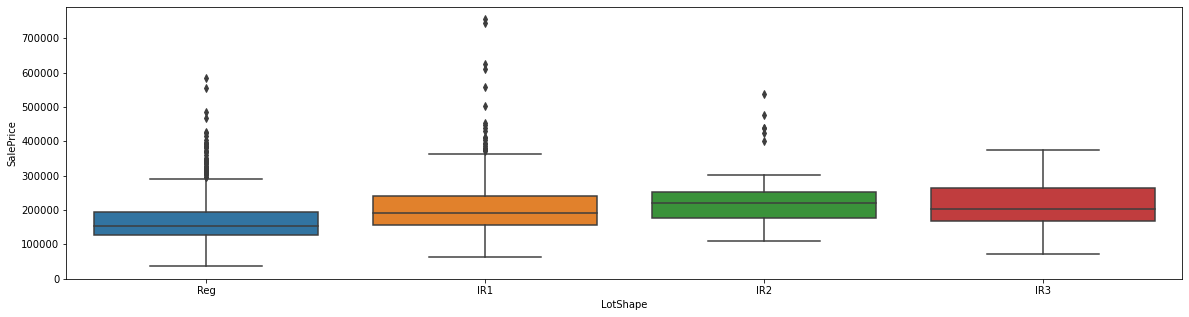

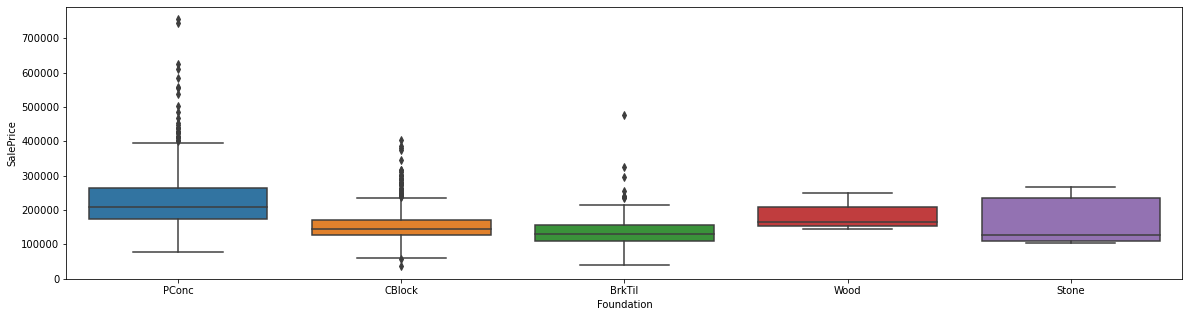

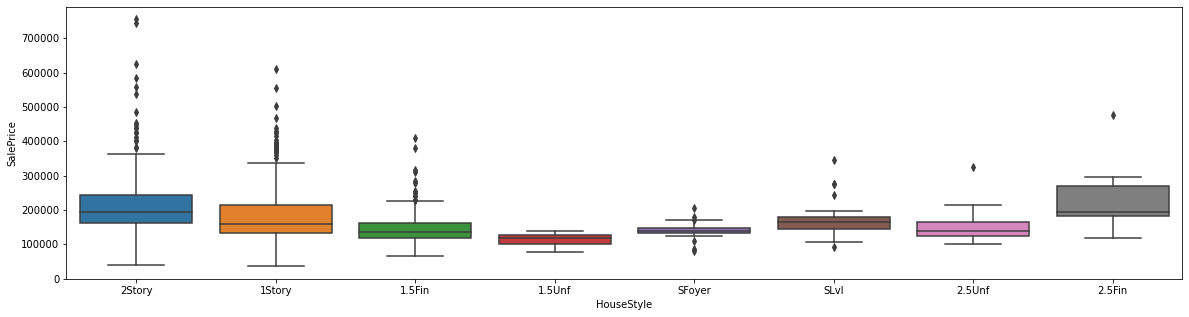

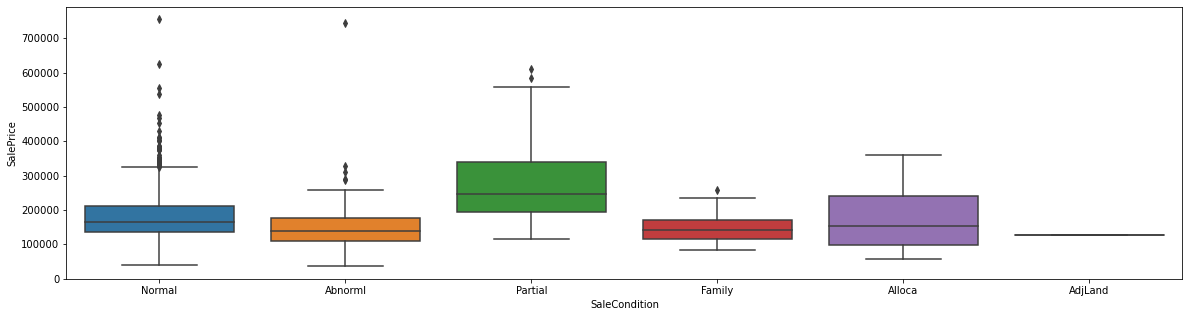

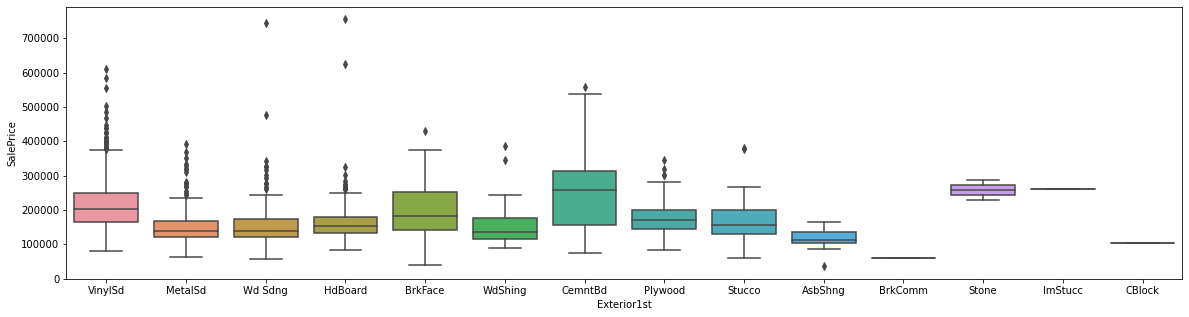

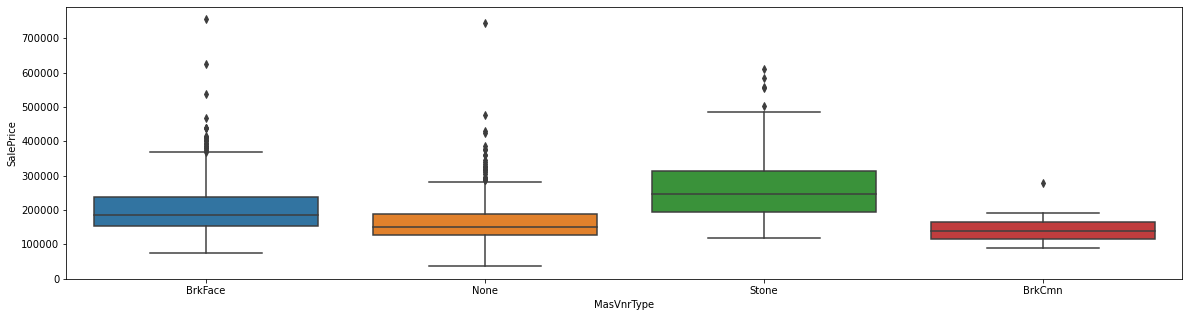

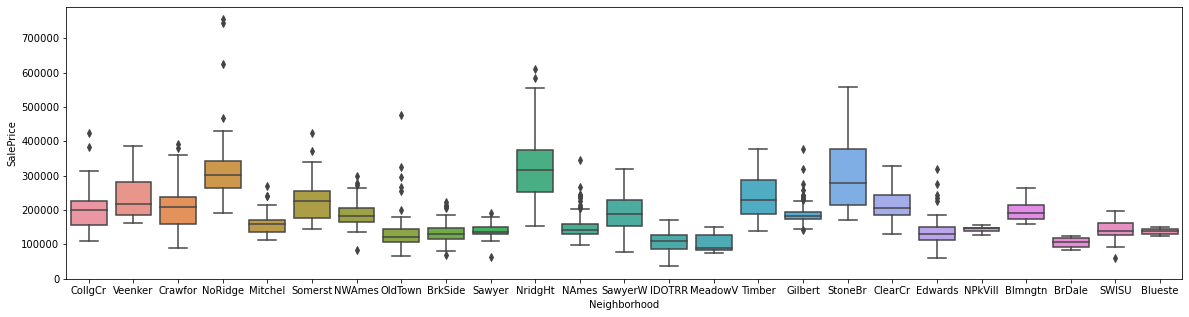

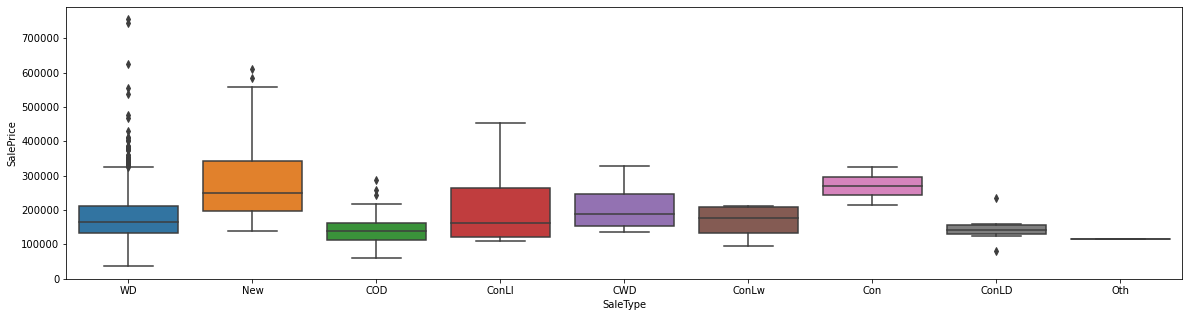

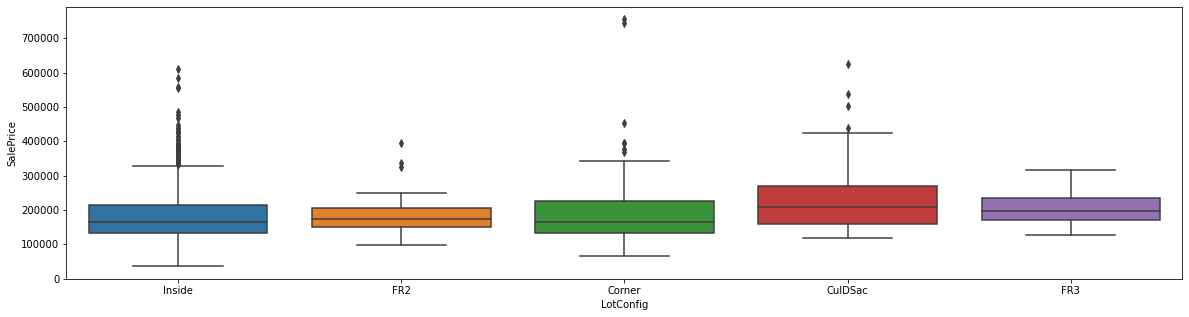

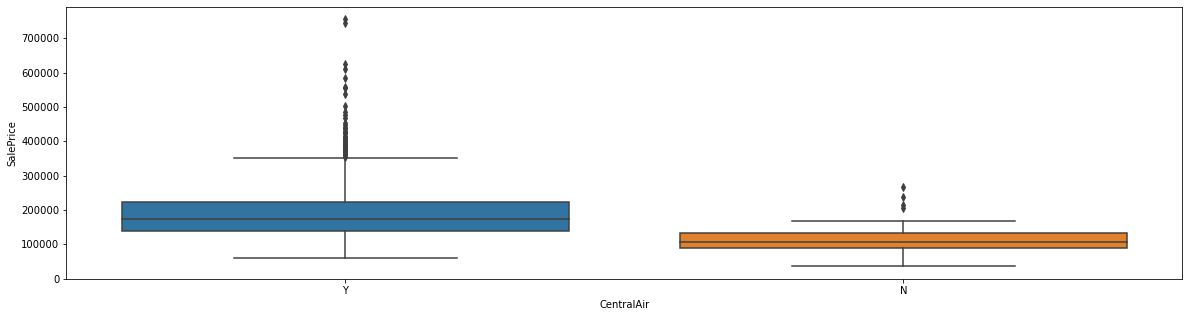

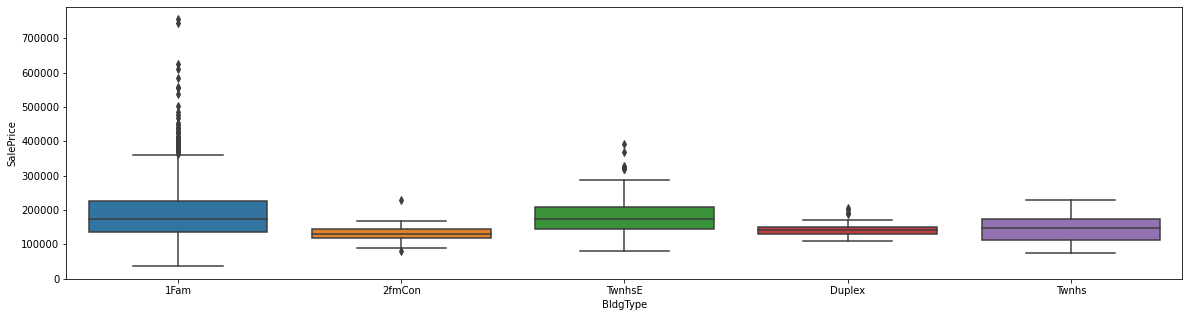

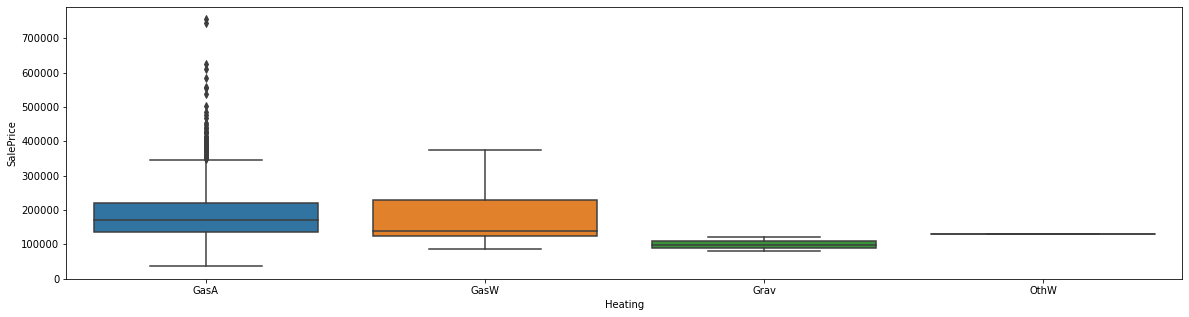

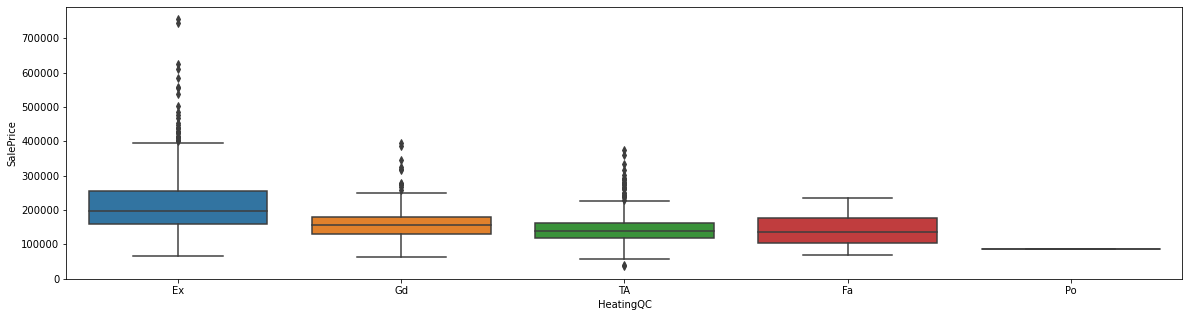

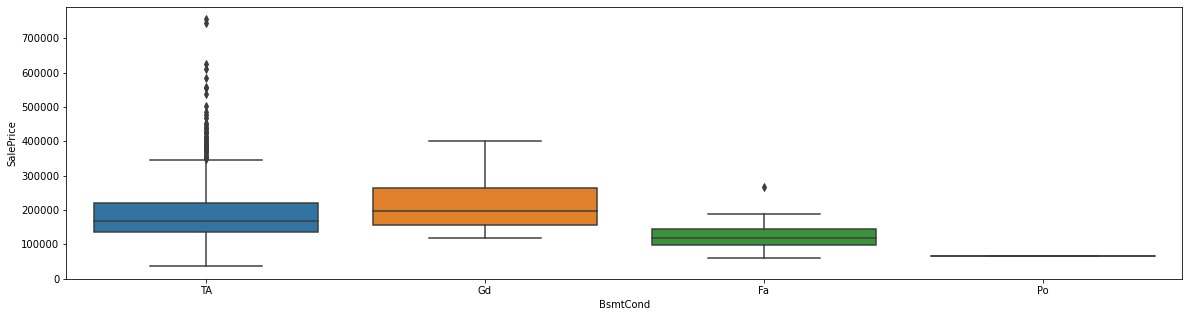

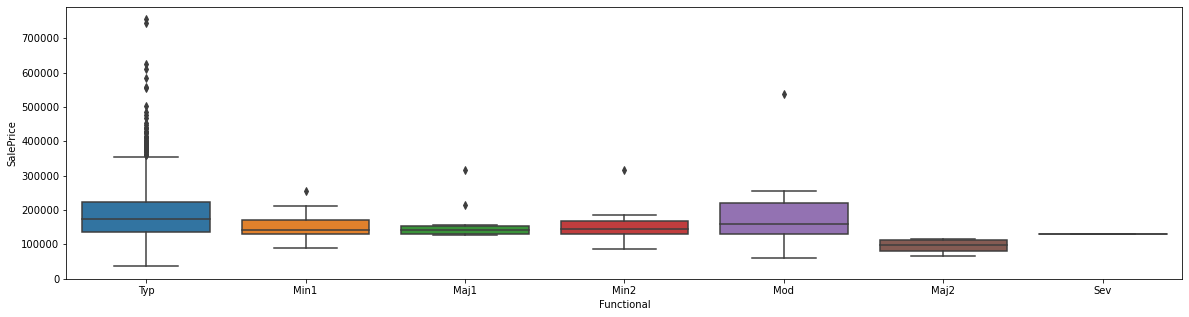

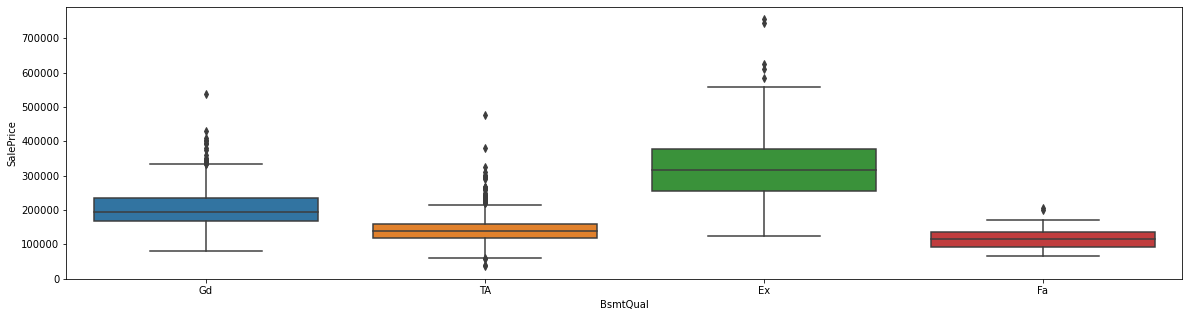

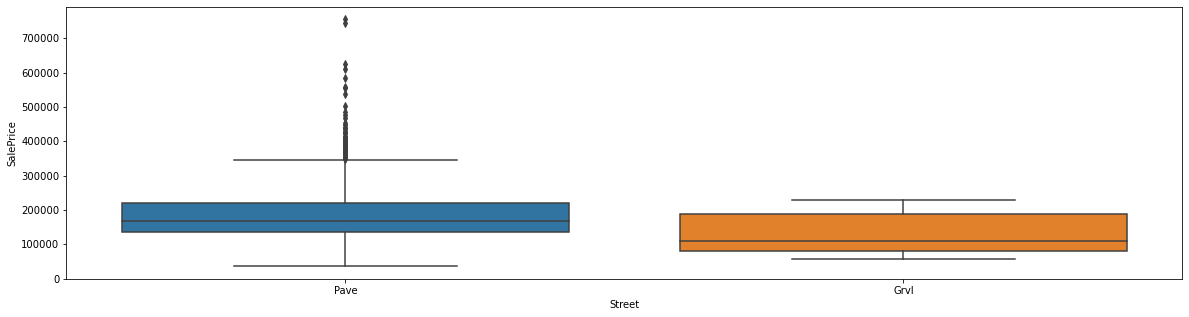

In [16]:
for var in cat_var:
    data = pd.concat([df['SalePrice'], df[var]], axis=1)
    f, ax = plt.subplots(figsize=(20, 5))
    fig = sns.boxplot(x=var, y="SalePrice", data=data)

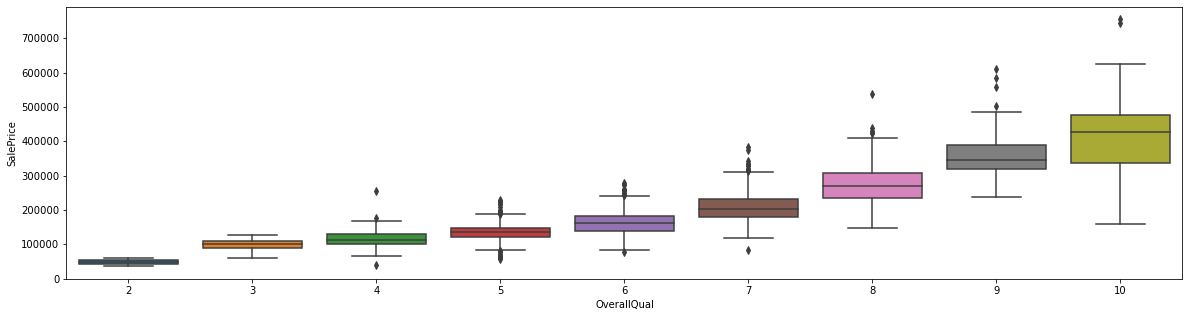

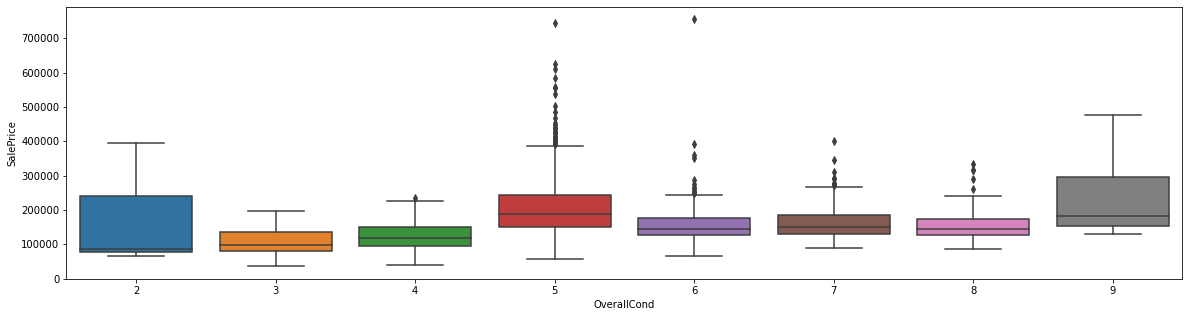

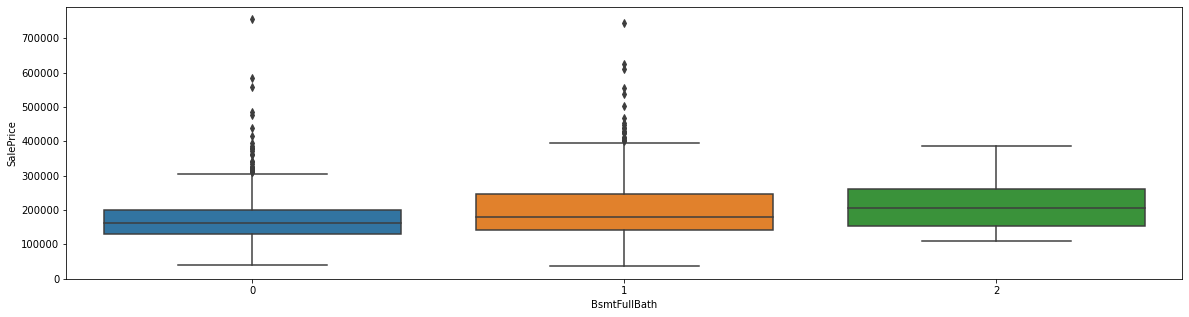

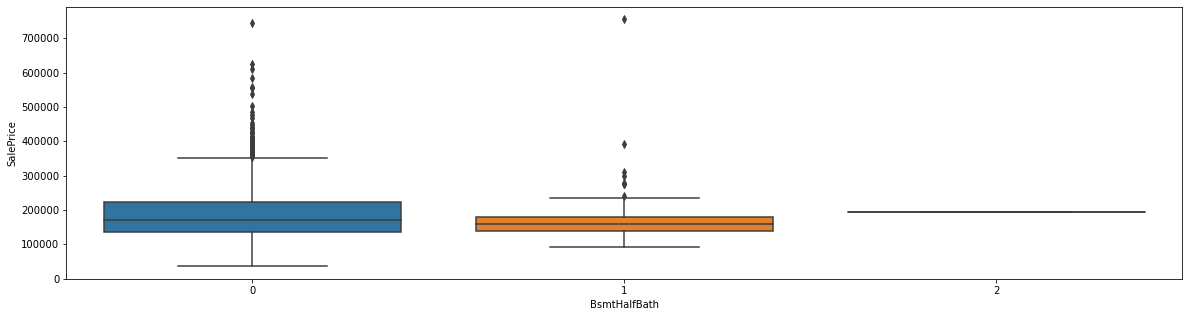

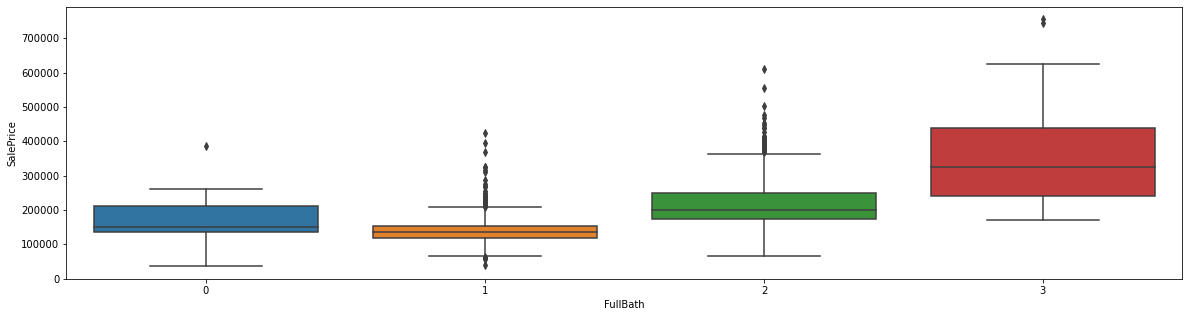

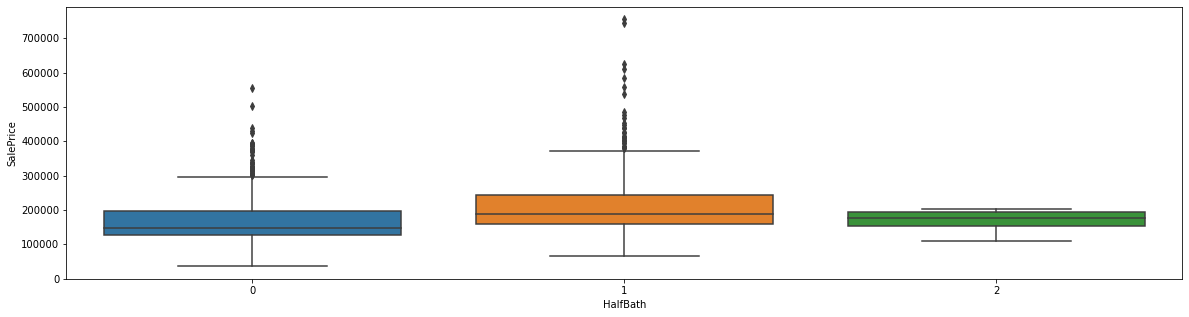

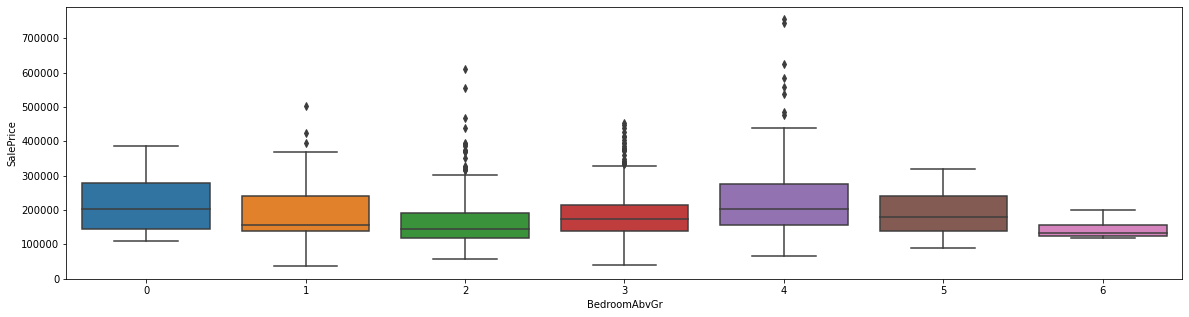

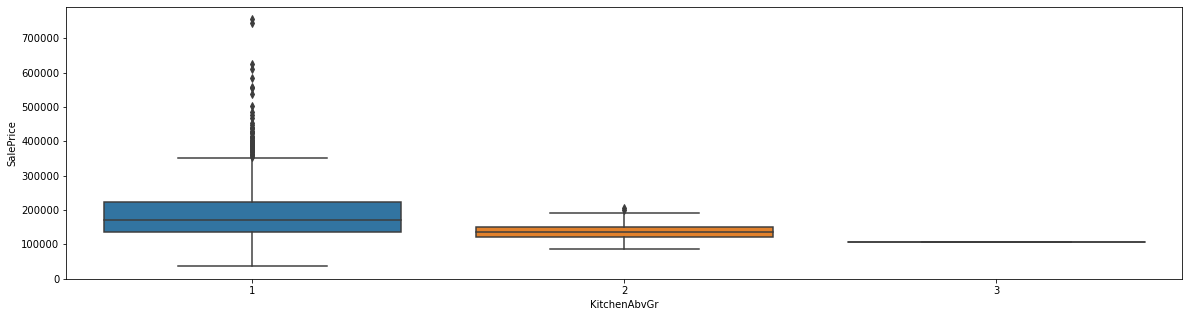

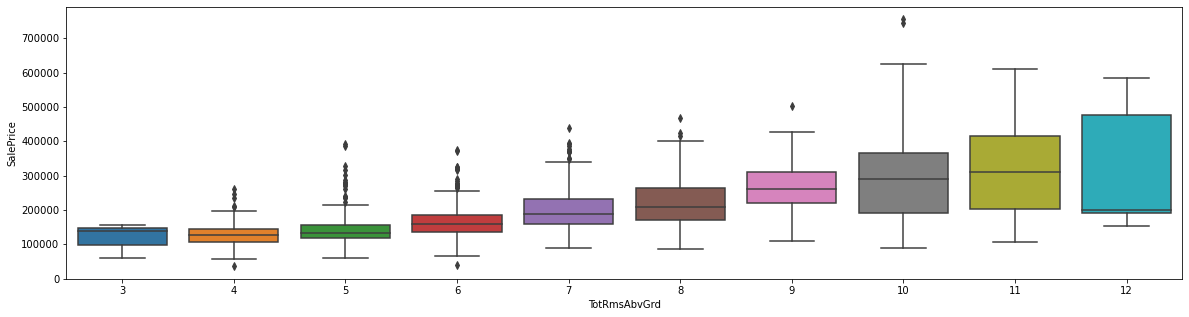

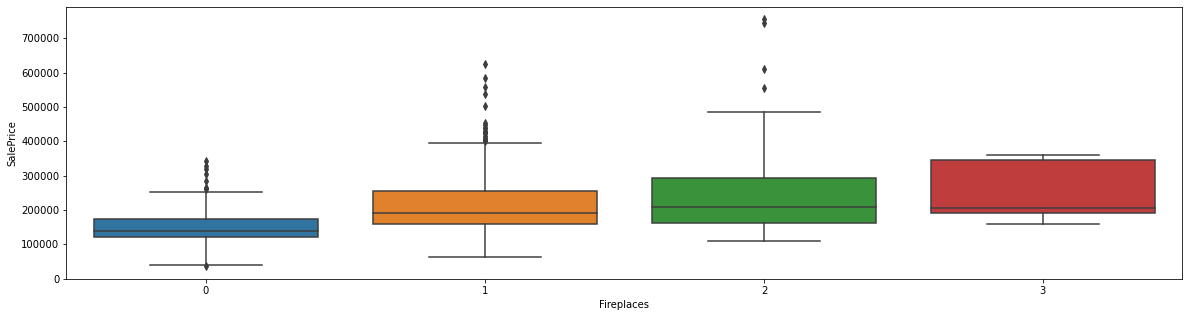

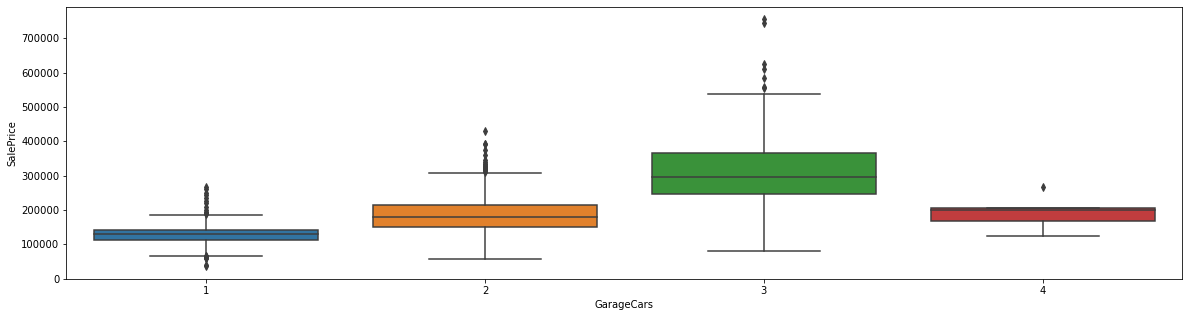

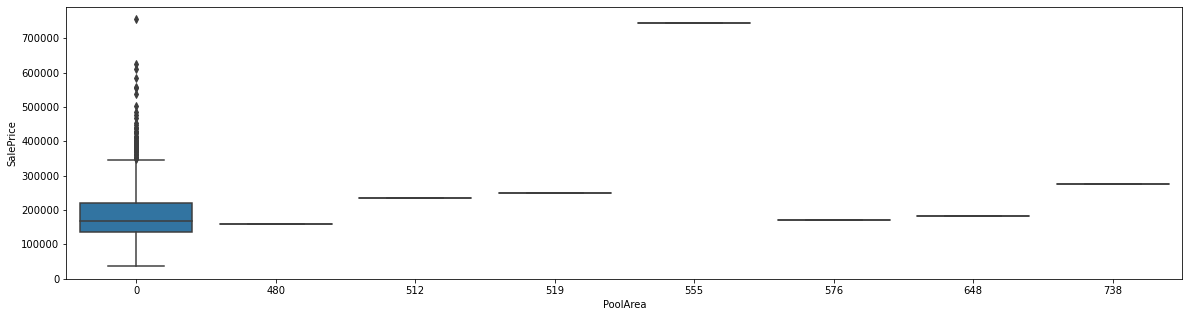

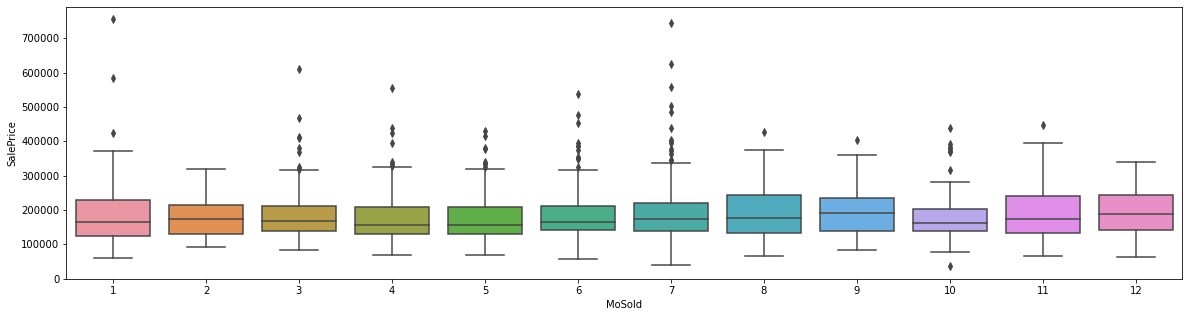

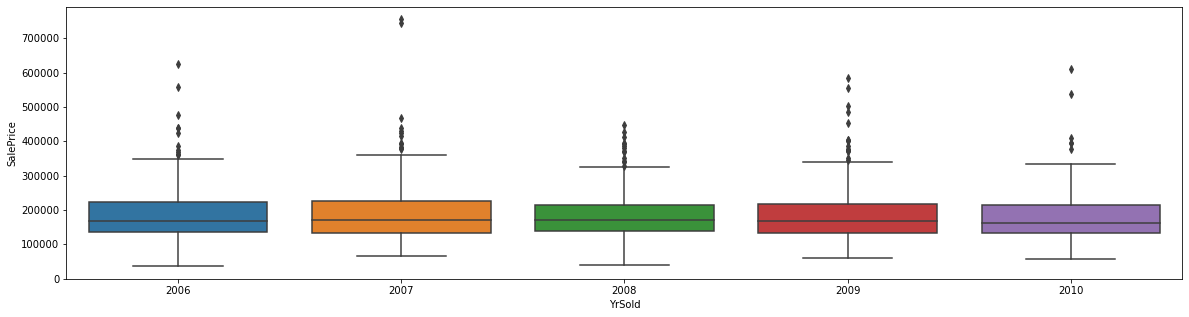

In [17]:
for var in num_var:
    if df[var].nunique() < 15:
        data = pd.concat([df['SalePrice'], df[var]], axis=1)
        f, ax = plt.subplots(figsize=(20, 5))
        fig = sns.boxplot(x=var, y="SalePrice", data=data)

# DATA PREPARATION

In [18]:
df.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


In [19]:
df = pd.get_dummies(df)
df.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,...,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,60,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,70,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,60,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [20]:
y = df[['SalePrice']]
X = df.drop('SalePrice', axis=1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

X_train.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,...,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.097844,0.028032,2.059291,-0.563107,0.903363,0.693139,0.511251,0.922672,-0.300769,-0.088245,0.818952,0.748442,0.707783,-0.100502,1.133572,1.101198,-0.254437,0.741515,1.183521,0.168005,-0.164300,0.907019,2.084917,0.852712,1.744723,1.233062,1.182785,1.434065,-0.356303,-0.126026,-0.274652,-0.080309,-0.087751,-0.528379,0.924008,-0.068519,-0.221404,-0.081149,0.508747,-0.416228,...,-0.086793,-0.030585,0.262547,-0.061256,0.764974,-0.130806,-0.276512,-0.068519,-0.612635,1.679711,-0.67365,-0.861784,-0.043274,-0.183892,-0.1065,-0.053025,0.22601,-0.030585,-0.144887,-0.075094,-0.075094,0.183892,-0.199611,-0.141489,0.248008,-0.178389,-0.053025,-0.030585,-0.053025,-0.061256,-0.061256,-0.322849,-0.030585,0.403786,-0.258456,-0.030585,-0.081149,-0.119239,0.469115,-0.326366
1,-0.863746,-0.389841,0.568465,-0.563107,1.105095,0.990039,-0.593024,-1.014004,-0.300769,1.599394,0.449384,0.288836,-0.816188,-0.100502,-0.471163,-0.856081,-0.254437,0.741515,-0.801381,-1.144152,-0.164300,-0.352566,0.543202,1.097861,0.183809,0.838081,0.521156,0.105841,-0.356303,-0.126026,-0.274652,-0.080309,-0.087751,0.210661,-1.341894,-0.068519,-0.221404,-0.081149,0.508747,-0.416228,...,-0.086793,-0.030585,0.262547,-0.061256,0.764974,-0.130806,-0.276512,-0.068519,-0.612635,-0.595341,1.48445,-0.861784,-0.043274,-0.183892,-0.1065,-0.053025,0.22601,-0.030585,-0.144887,-0.075094,-0.075094,0.183892,-0.199611,-0.141489,0.248008,-0.178389,-0.053025,-0.030585,-0.053025,-0.061256,-0.061256,3.097428,-0.030585,-2.476557,-0.258456,-0.030585,-0.081149,-0.119239,-2.131676,3.064041
2,-0.863746,-0.347157,-0.922362,1.302293,-0.777736,-1.781035,-0.593024,0.130006,0.274321,-0.740799,-0.534530,-0.483908,-0.816188,-0.100502,-1.042815,-0.856081,-0.254437,-1.061714,-0.801381,0.168005,-0.164300,-0.352566,-0.998512,-1.190193,-1.377106,-1.222227,-0.786535,0.487515,-0.356303,-0.126026,-0.274652,-0.080309,-0.087751,-0.528379,-0.586593,-0.068519,-0.221404,-0.081149,0.508747,-0.416228,...,-0.086793,-0.030585,0.262547,-0.061256,0.764974,-0.130806,-0.276512,-0.068519,-0.612635,-0.595341,-0.67365,1.160384,-0.043274,-0.183892,-0.1065,-0.053025,0.22601,-0.030585,-0.144887,-0.075094,-0.075094,0.183892,-0.199611,-0.141489,0.248008,-0.178389,-0.053025,-0.030585,-0.053025,-0.061256,-0.061256,-0.322849,-0.030585,0.403786,-0.258456,-0.030585,-0.081149,-0.119239,0.469115,-0.326366
3,3.223012,0.276534,-0.922362,-0.563107,-2.458835,-1.781035,-0.593024,-1.014004,-0.300769,0.195278,-1.048085,0.612076,1.243537,-0.100502,1.477311,-0.856081,-0.254437,0.741515,-0.801381,2.792318,5.695745,2.166603,-0.998512,-1.394483,0.183809,0.293647,-0.786535,0.136375,-0.356303,-0.126026,-0.274652,-0.080309,-0.087751,0.949701,-0.586593,-0.068519,-0.221404,-0.081149,-1.965613,2.402530,...,-0.086793,-0.030585,-3.808838,-0.061256,-1.307234,-0.130806,-0.276512,-0.068519,1.632294,-0.595341,-0.67365,1.160384,-0.043274,-0.183892,-0.1065,-0.053025,0.22601,-0.030585,-0.144887,-0

# MACHINE LEARNING

## Random Forest

In [23]:
rfr = RandomForestRegressor(random_state=42)

param_grid = { 
    'max_depth' : list(np.linspace(2, 10, 10, dtype=int)),
    'n_estimators': list(np.linspace(100, 500, 10, dtype=int))
}

# not using GridSearchCV beacuse it would be to long to try all
cv_rfr = RandomizedSearchCV(rfr, param_grid, n_iter=5, verbose=1)
cv_rfr.fit(X_train, y_train.values.ravel())

cv_rfr.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'n_estimators': 188, 'max_depth': 9}

In [24]:
y_pred = cv_rfr.predict(X_test)
rmse_rfr = mean_squared_error(y_test, y_pred, squared=False)
mape_rfr = mean_absolute_percentage_error(y_test, y_pred)
r2_score_rfr = r2_score(y_test, y_pred)

print(f'RMSE: {rmse_rfr:.0f} | MAPE: {100*mape_rfr:.1f}% | R2 score: {r2_score_rfr:.3f}')

RMSE: 26717 | MAPE: 10.9% | R2 score: 0.833


<AxesSubplot:xlabel='Feature'>

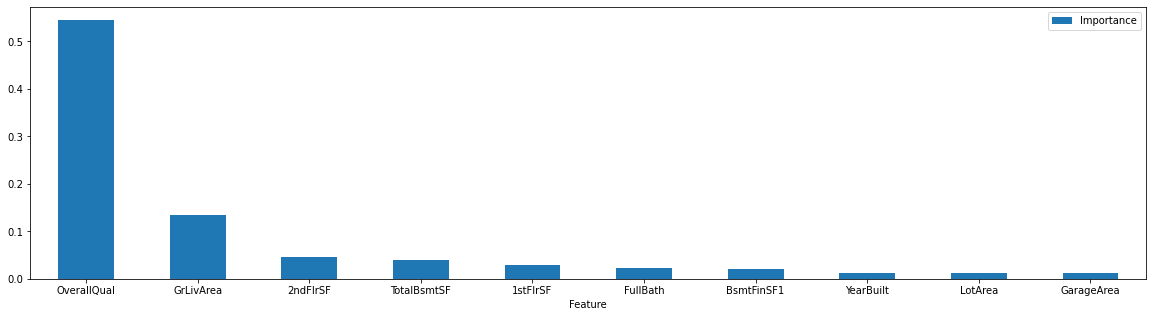

In [25]:
plt.rcParams["figure.figsize"] = (20, 5)

fi_rfr = pd.DataFrame(columns=['Feature', 'Importance'])
fi_rfr.Feature = X.columns
fi_rfr.Importance = cv_rfr.best_estimator_.feature_importances_
sorted_fi_rfr = fi_rfr.sort_values(by='Importance', ascending=False).head(10)

sorted_fi_rfr.plot.bar(x='Feature', y='Importance', rot=0)

## XGBoost

In [26]:
xgbr = XGBRegressor(random_state=42)

param_grid = {
    'max_depth' : list(np.linspace(3, 11, 5, dtype=int)),
    'n_estimators': list(np.linspace(100, 500, 5, dtype=int)),
    'learning_rate': list(np.linspace(0.01, 0.3, 5)),
    'colsample_bytree': list(np.linspace(0.5, 1, 5)),
    'subsample': list(np.linspace(0.6, 1, 5)),
}

cv_xgbr = RandomizedSearchCV(xgbr, param_grid, n_iter=5, verbose=1)
cv_xgbr.fit(X_train, y_train.values.ravel())

cv_xgbr.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'subsample': 1.0,
 'n_estimators': 300,
 'max_depth': 3,
 'learning_rate': 0.22749999999999998,
 'colsample_bytree': 0.75}

In [27]:
y_pred = cv_xgbr.predict(X_test)
rmse_xgbr = mean_squared_error(y_test, y_pred, squared=False)
mape_xgbr = mean_absolute_percentage_error(y_test, y_pred)
r2_score_xgbr = r2_score(y_test, y_pred)

print(f'RMSE: {rmse_xgbr:.0f} | MAPE: {100*mape_xgbr:.1f}% | R2 score: {r2_score_xgbr:.3f}')

RMSE: 25334 | MAPE: 9.4% | R2 score: 0.850


<AxesSubplot:xlabel='Feature'>

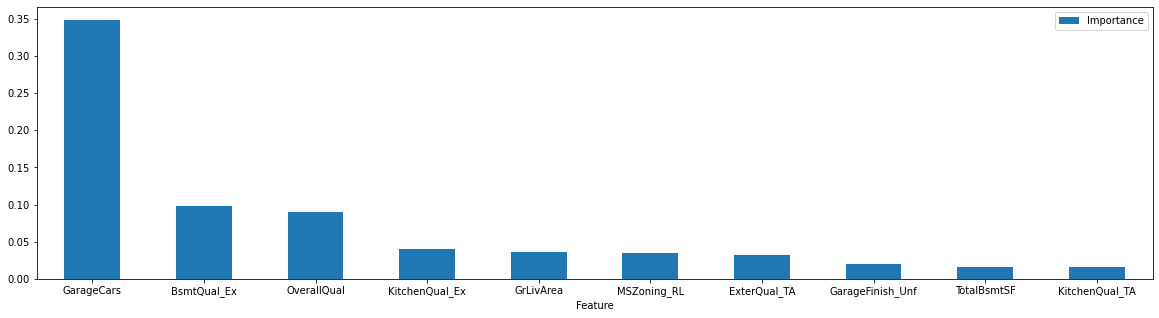

In [28]:
plt.rcParams["figure.figsize"] = (20, 5)

fi_xgbr = pd.DataFrame(columns=['Feature', 'Importance'])
fi_xgbr.Feature = X.columns
fi_xgbr.Importance = cv_xgbr.best_estimator_.feature_importances_
sorted_fi_xgbr = fi_xgbr.sort_values(by='Importance', ascending=False).head(10)

sorted_fi_xgbr.plot.bar(x='Feature', y='Importance', rot=0)